In [224]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from datetime import datetime
import seaborn as sns

from imblearn.over_sampling import SMOTE
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

In [225]:
ROOT_PATH = Path().resolve().parent
dataset_path = ROOT_PATH / "data/airlines_delay.csv"

In [226]:
dataset = pd.read_csv(dataset_path, sep=",")
dataset.head()

,Flight,Time,Length,Airline,AirportFrom,AirportTo,DayOfWeek,Class
0,2313.0,1296.0,141.0,DL,ATL,HOU,1,0
1,6948.0,360.0,146.0,OO,COS,ORD,4,0
2,1247.0,1170.0,143.0,B6,BOS,CLT,3,0
3,31.0,1410.0,344.0,US,OGG,PHX,6,0
4,563.0,692.0,98.0,FL,BMI,ATL,4,0


In [227]:
dataset.dtypes

Flight         float64
Time           float64
Length         float64
Airline         object
AirportFrom     object
AirportTo       object
DayOfWeek        int64
Class            int64
dtype: object

In [228]:
dataset.describe()

,Flight,Time,Length,DayOfWeek,Class
count,539382.000000,539382.000000,539382.000000,539382.000000,539382.000000
mean,2427.927988,802.728161,132.202104,3.929666,0.445443
std,2067.431700,278.045546,70.117045,1.914666,0.497015
min,1.000000,10.000000,0.000000,1.000000,0.000000
25%,712.000000,565.000000,81.000000,2.000000,0.000000
50%,1809.000000,795.000000,115.000000,4.000000,0.000000
75%,3745.000000,1035.000000,162.000000,5.000000,1.000000
max,7814.000000,1439.000000,655.000000,7.000000,1.000000


In [229]:
print("Amount of Airlines:", len(dataset["Airline"].unique()))
print("Amount of AirportFrom:", len(dataset["AirportFrom"].unique()))
print("Amount of AirportTo:", len(dataset["AirportTo"].unique()))

Amount of Airlines: 18
Amount of AirportFrom: 293
Amount of AirportTo: 293


Too much Airlines and Places to make it binary as dummy.\
In this case I'll only make them become 'Factors'

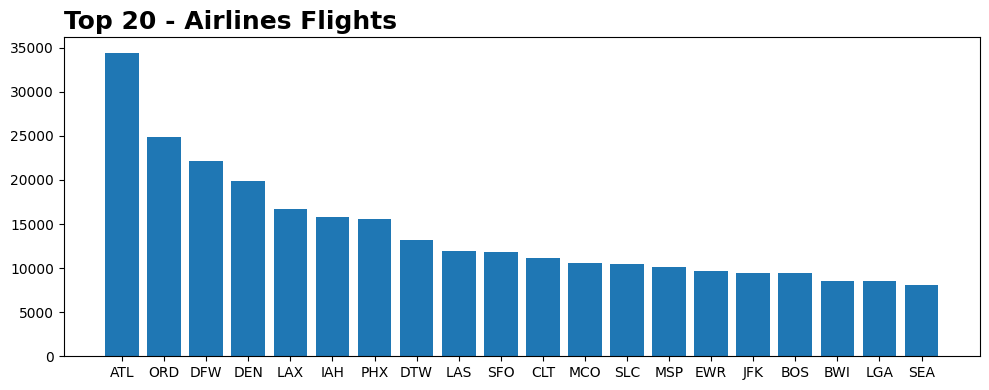

In [230]:
mostFlownAirlines = dataset.groupby(["AirportFrom"])["Airline"].count().sort_values(ascending=False)[:20]

plt.figure(figsize=(10, 4))
plt.bar(x=mostFlownAirlines.index, height=mostFlownAirlines.values)
plt.title(
    "Top 20 - Airlines Flights", 
    loc="left", 
    fontweight="bold", 
    fontsize=18
    )
plt.tight_layout()
plt.show()

#### Days with the major amount of Flights

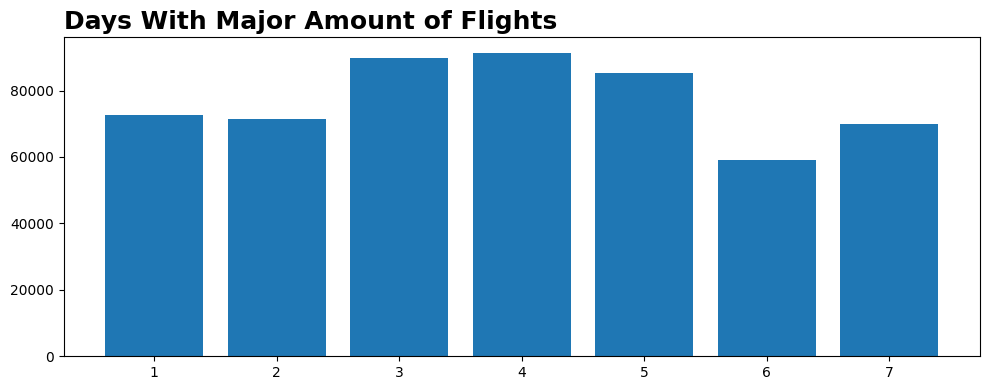

In [231]:
mostFlownDays = dataset.groupby(["DayOfWeek"])["DayOfWeek"].count().sort_values(ascending=False)

plt.figure(figsize=(10, 4))
plt.bar(x=mostFlownDays.index, height=mostFlownDays.values)
plt.title(
    "Days With Major Amount of Flights", 
    loc="left", 
    fontweight="bold", 
    fontsize=18
    )
plt.tight_layout()
plt.show()

Wednesday has more flights compared to the other days

#### Airline Flights Per Day

In [232]:
mostFlownDaysPerAirline = [
    (
    airline, 
    dataset[dataset["Airline"]==airline].groupby(
        ["DayOfWeek"]
        )["DayOfWeek"].count()
        ) for airline in dataset["Airline"].unique()
        ]

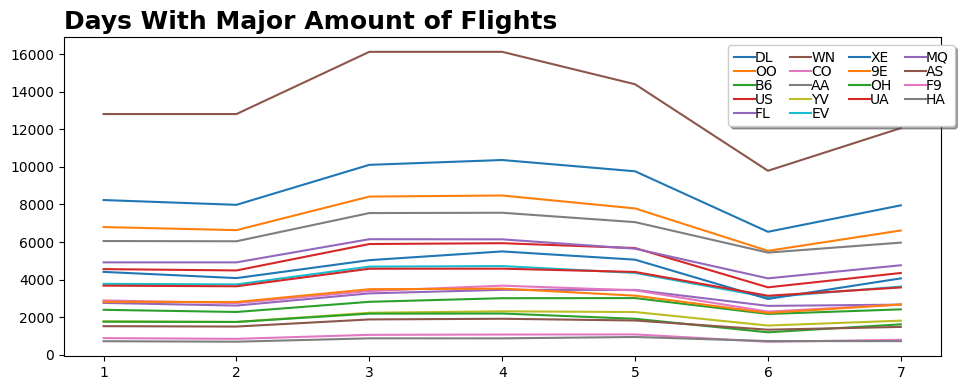

In [233]:
plt.figure(figsize=(10, 4))

for airline_takeOffs in mostFlownDaysPerAirline:
    legend = airline_takeOffs[0]
    index_input = airline_takeOffs[1].index
    dados_input = airline_takeOffs[1].values
    plt.plot(index_input, dados_input)
    plt.title(
        "Days With Major Amount of Flights", 
        loc="left", 
        fontweight="bold", 
        fontsize=18
        )
    plt.legend(
        dataset["Airline"].unique(), loc="best", ncols=4, 
        bbox_to_anchor=[0.75, 0.7], 
        columnspacing=1.0, labelspacing=0.0,
        handletextpad=0.0, handlelength=1.5,
        fancybox=True, shadow=True
        )

plt.tight_layout()
plt.show()

#### Days with the most Delaied Flights (Checking Data Balancing)

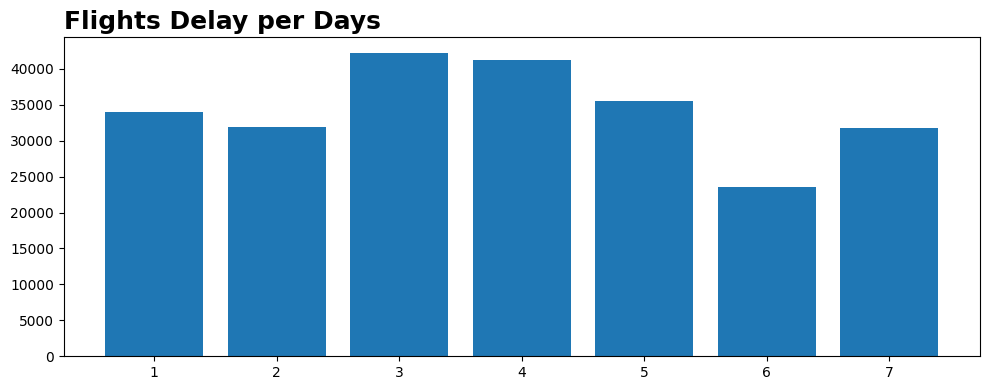

In [234]:
mostDelaiedDays = dataset.query("Class == 1")["DayOfWeek"].value_counts()

plt.figure(figsize=(10, 4))
plt.bar(x=mostDelaiedDays.index, height=mostDelaiedDays.values) #type: ignore
plt.title(
    "Flights Delay per Days", 
    loc="left", 
    fontweight="bold", 
    fontsize=18
    )
plt.tight_layout()
plt.show()

Tuesday has more delaied flights than the other days

## Category Balance Analysis

<Axes: xlabel='Class'>

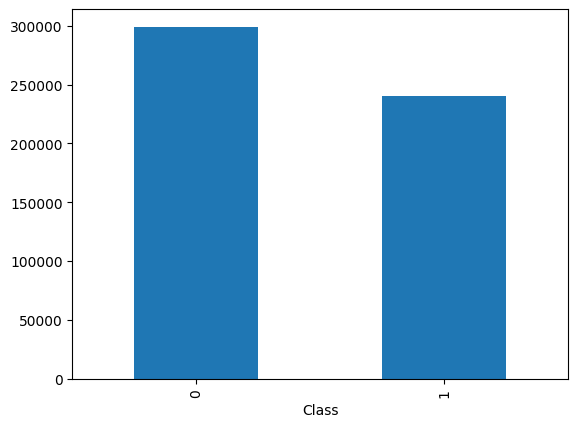

In [235]:
dataset["Class"].value_counts().plot(kind="bar")

In [236]:
class_0 = dataset['Class'].value_counts()[0]
class_1 = dataset['Class'].value_counts()[1]

diff_class_percent = ((class_0/ class_1)-1) *100
print(f"Class 0, contains: {class_0} values")
print(f"Class 1, contains: {class_1} values")
print(
    f"Difference between classes is: {round(diff_class_percent, ndigits=2)}%"
    )

Class 0, contains: 299118 values
Class 1, contains: 240264 values
Difference between classes is: 24.5%


Nearly 25% of difference between both classes.\
It is not a HUGE difference, but we can work on it, to make a gap reduction.\
Leater we'll do a SMOTE to fill up this smaller class.

## Feature Engineering

In [237]:
airline_size = range(len(dataset["Airline"].unique()))
airline_names = dataset["Airline"].unique()
factor_airline = dict(zip(airline_names, airline_size))

airport_from_size = range(len(dataset["AirportFrom"].unique()))
airport_from_names = dataset["AirportFrom"].unique()
factor_airport_from = dict(zip(airport_from_names, airport_from_size))

airport_to_size = range(len(dataset["AirportTo"].unique()))
airport_to_names = dataset["AirportTo"].unique()
factor_airport_to = dict(zip(airport_to_names, airport_to_size))

In [238]:
dataset_v1 = dataset.copy()
dataset_v1["Airline"] = dataset_v1["Airline"].map(factor_airline)
dataset_v1["AirportFrom"] = dataset_v1["AirportFrom"].map(factor_airport_from)
dataset_v1["AirportTo"] = dataset_v1["AirportTo"].map(factor_airport_to)

In [239]:
dataset_v1.drop(["Flight"], axis=1, inplace=True)

In [240]:
dataset_v1.head()

,Time,Length,Airline,AirportFrom,AirportTo,DayOfWeek,Class
0,1296.0,141.0,0,0,0,1,0
1,360.0,146.0,1,1,1,4,0
2,1170.0,143.0,2,2,2,3,0
3,1410.0,344.0,3,3,3,6,0
4,692.0,98.0,4,4,4,4,0


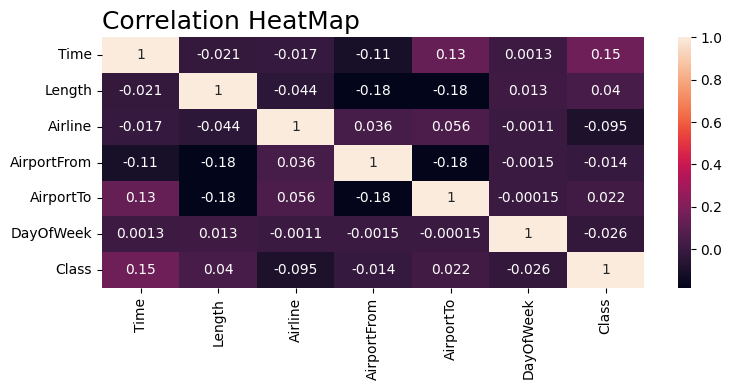

In [241]:
correlation = dataset_v1.corr()
plt.figure(figsize=(8,4))
sns.heatmap(correlation, annot=True)
plt.title("Correlation HeatMap", loc="left", fontsize=18)
plt.tight_layout()
plt.show()

In [242]:
dummyDaysOfWeek = pd.get_dummies(dataset_v1["DayOfWeek"], dtype=int)
dataset_v2 = dataset_v1.join(dummyDaysOfWeek)

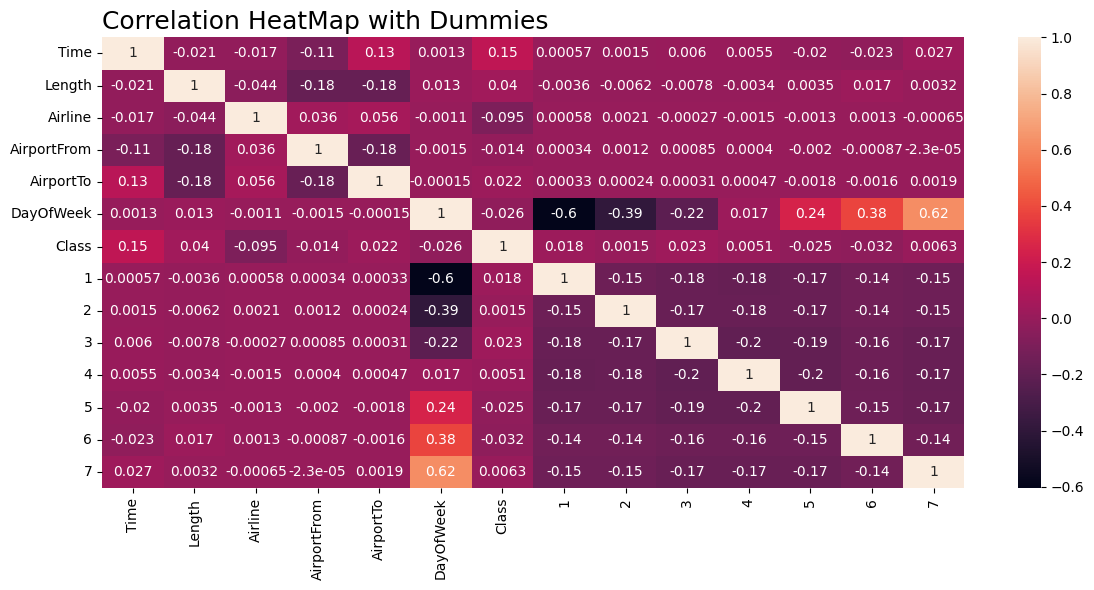

In [243]:
correlation = dataset_v2.corr()
plt.figure(figsize=(12,6))
sns.heatmap(correlation, annot=True)
plt.title("Correlation HeatMap with Dummies", loc="left", fontsize=18)
plt.tight_layout()
plt.show()

In [244]:
dataset_v3 = dataset_v1.copy()
dataset_v3["TimeDistance"] = dataset_v3["Length"] / (dataset_v3["Time"] / 60 ) # Transforming "Time" to Hours
# I'm treating "Time" as Minutes

dataset_v3.corr()

,Time,Length,Airline,AirportFrom,AirportTo,DayOfWeek,Class,TimeDistance
Time,1.000000,-0.020610,-0.016846,-0.107336,0.128246,0.001272,0.150457,-0.309539
Length,-0.020610,1.000000,-0.044329,-0.179976,-0.183904,0.013398,0.040488,0.341990
Airline,-0.016846,-0.044329,1.000000,0.036427,0.055764,-0.001144,-0.095255,-0.022685
AirportFrom,-0.107336,-0.179976,0.036427,1.000000,-0.176637,-0.001454,-0.013599,-0.038342
AirportTo,0.128246,-0.183904,0.055764,-0.176637,1.000000,-0.000152,0.022031,-0.093403
DayOfWeek,0.001272,0.013398,-0.001144,-0.001454,-0.000152,1.000000,-0.026198,0.002863
Class,0.150457,0.040488,-0.095255,-0.013599,0.022031,-0.026198,1.000000,-0.022563
TimeDistance,-0.309539,0.341990,-0.022685,-0.038342,-0.093403,0.002863,-0.022563,1.000000


None activites done in dataset v2, or v3 increased the variables correlation\
In this case, we'll keep with the dataset_v1 with the "basic" data

## Dividing Data into X: Attribute Variables and Y: Target Varible

In [245]:
y = dataset_v1.loc[:,"Class"]
X = dataset_v1.drop(["Class"], axis=1)

In [246]:
X

,Time,Length,Airline,AirportFrom,AirportTo,DayOfWeek
0,1296.0,141.0,0,0,0,1
1,360.0,146.0,1,1,1,4
2,1170.0,143.0,2,2,2,3
3,1410.0,344.0,3,3,3,6
4,692.0,98.0,4,4,4,4
...,...,...,...,...,...,...
539377,530.0,72.0,1,96,51,5
539378,560.0,115.0,5,49,12,4
539379,827.0,74.0,9,74,4,2
539380,715.0,65.0,5,8,33,4


### Checking VIF (Variance Inflation Factor)

In [247]:
vif = pd.DataFrame()
vif["features"] = X.columns
vif["VIF Factor"] = [variance_inflation_factor(
    X.values, 
    i) 
    for i in range(X.shape[1])]

vif

,features,VIF Factor
0,Time,6.022435
1,Length,3.690119
2,Airline,2.674671
3,AirportFrom,1.907044
4,AirportTo,1.910198
5,DayOfWeek,4.322651


Be aware that AirportFrom and AirportTo have pratically the same VIF\
It means that both variables might have the same meaning to the Classification Model

### Data Balancing

Balancing the Target Variables "Class" which was with a smaller amount of classes 1

In [248]:
overSampler = SMOTE()
X_res, y_res = overSampler.fit_resample(X, y)

In [249]:
print(X_res.shape)
print(y_res.shape)
print(dataset_v1.shape)

(598236, 6)
(598236,)
(539382, 7)


<Axes: xlabel='Class'>

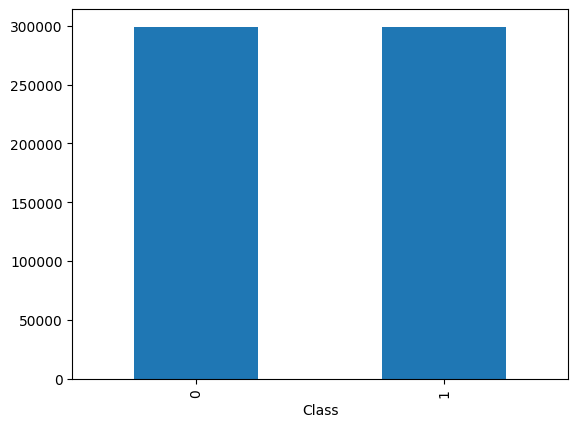

In [250]:
y_res.value_counts().plot(kind="bar")

In [251]:
print(y_res.value_counts()[0])
print(y_res.value_counts()[1])

299118
299118


The gap between classes was reduced to Zero.\
Now we can proceed to the Modeling

## Model Development

In [252]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, shuffle=True
)

### Base Model

In [253]:
base_model = LogisticRegression()
base_model = base_model.fit(X_train, y_train)
base_model_result = base_model.predict(X_test)

In [254]:
score_base_model = round(accuracy_score(y_test, base_model_result) * 100, ndigits=2)
print(score_base_model, "%",  "\n")
print(pd.DataFrame(confusion_matrix(y_test, base_model_result)))

58.19 % 

       0      1
0  68775  21099
1  46548  25393


According to the VIF analysis, there were two variables with almost the same influence.\
If we take one of these variables out of the model, which are the impacts we'll have?


In [255]:
base_model_v2 = LogisticRegression()
base_model_v2 = base_model_v2.fit(X_train.drop(["AirportTo"], axis=1), y_train)
base_model_v2_result = base_model_v2.predict(X_test.drop(["AirportTo"], axis=1))

score_base_model_v2 = round(accuracy_score(y_test, base_model_v2_result) * 100, ndigits=2)
print(score_base_model_v2, "%",  "\n")
print(pd.DataFrame(confusion_matrix(y_test, base_model_v2_result)))

58.15 % 

       0      1
0  68744  21130
1  46591  25350


In [256]:
X_train["Time"] =  np.log(X_train["Time"])
X_train["Length"] =  np.log(X_train["Time"])

X_test["Time"] =  np.log(X_test["Time"])
X_test["Length"] =  np.log(X_test["Time"])

There wasn't a big impact in model's performance.\
Although, when we take a look at the False Positive and True Positive\
The model's Precision in better with both variables.

With the base model we couldn't achieve a good accuracy score, then I'll keep on with other Models/Hiperparameters.

In [257]:
def results(y_true, y_result):

    precision = precision_score(y_true, y_result) * 100
    accuracy = accuracy_score(y_true, y_result) * 100
    recall = recall_score(y_true, y_result) * 100
    conf_matrix = confusion_matrix(y_true, y_result)

    print("Model's precision: ", round(precision, ndigits=2))
    print("Model's accuracy: ", round(accuracy, ndigits=2))
    print("Model's recall: ", round(recall, ndigits=2), "\n")
    print("Model's Confusion Matrix:",)
    print(pd.DataFrame(conf_matrix))

In [258]:
model_log_reg_v1 = LogisticRegression()
model_log_reg_v1.fit(X_train, y_train)

result_log_reg_v1 = model_log_reg_v1.predict(X_test)
results(y_test, result_log_reg_v1)

Model's precision:  54.71
Model's accuracy:  58.41
Model's recall:  37.48 

Model's Confusion Matrix:
       0      1
0  67557  22317
1  44979  26962


In [259]:
model_log_reg_v2 = LogisticRegression(C=0.5, n_jobs=5, max_iter=200, solver="newton-cholesky")
model_log_reg_v2.fit(X_train, y_train)

result_log_reg_v2 = model_log_reg_v2.predict(X_test)
results(y_test, result_log_reg_v2)

Model's precision:  54.69
Model's accuracy:  58.39
Model's recall:  37.38 

Model's Confusion Matrix:
       0      1
0  67596  22278
1  45051  26890


Model is not answering the hyperparameters modification. Let's try another model

In [260]:
model_decisiontree_v1 = DecisionTreeClassifier()
model_decisiontree_v1.fit(X_train, y_train)

result_decisiontree_v1 = model_decisiontree_v1.predict(X_test)
results(y_test, result_decisiontree_v1)

Model's precision:  57.48
Model's accuracy:  61.0
Model's recall:  47.13 

Model's Confusion Matrix:
       0      1
0  64798  25076
1  38038  33903


In [261]:
model_decisiontree_v2 = DecisionTreeClassifier(
    max_depth=3, min_samples_split=2,
    min_samples_leaf=1
    )
model_decisiontree_v2.fit(X_train, y_train)

result_decisiontree_v2 = model_decisiontree_v2.predict(X_test)
results(y_test, result_decisiontree_v2)

Model's precision:  73.7
Model's accuracy:  63.19
Model's recall:  26.75 

Model's Confusion Matrix:
       0      1
0  83005   6869
1  52695  19246


Now doing the same checking but with RandomForestClassifier

In [269]:
model_randomforest_v1 = RandomForestClassifier()
model_randomforest_v1.fit(X_train, y_train)

result_randomforest_v1 = model_randomforest_v1.predict(X_test)
results(y_test, result_randomforest_v1)

Model's precision:  57.53
Model's accuracy:  61.95
Model's recall:  55.05 

Model's Confusion Matrix:
       0      1
0  60639  29235
1  32335  39606


In [270]:
model_randomforest_v2 = RandomForestClassifier(n_estimators=150, max_depth=3)
model_randomforest_v2.fit(X_train, y_train)

result_randomforest_v2 = model_randomforest_v2.predict(X_test)
results(y_test, result_randomforest_v2)

Model's precision:  59.44
Model's accuracy:  62.16
Model's recall:  46.85 

Model's Confusion Matrix:
       0      1
0  66871  23003
1  38234  33707


In [271]:
model_randomforest_v3 = RandomForestClassifier(n_estimators=150, max_depth=6)
model_randomforest_v3.fit(X_train, y_train)

result_randomforest_v3 = model_randomforest_v3.predict(X_test)
results(y_test, result_randomforest_v3)

Model's precision:  64.04
Model's accuracy:  63.74
Model's recall:  42.04 

Model's Confusion Matrix:
       0      1
0  72894  16980
1  41696  30245


In [272]:
model_randomforest_v4 = RandomForestClassifier(
    n_estimators=150, max_depth=6, criterion="entropy"
    )

model_randomforest_v4.fit(X_train, y_train)

result_randomforest_v4 = model_randomforest_v4.predict(X_test)
results(y_test, result_randomforest_v4)

Model's precision:  64.22
Model's accuracy:  63.77
Model's recall:  41.78 

Model's Confusion Matrix:
       0      1
0  73124  16750
1  41883  30058


In [273]:
model_randomforest_v5 = RandomForestClassifier(
    n_estimators=150, max_depth=8, 
    )

model_randomforest_v5.fit(X_train, y_train)

result_randomforest_v5 = model_randomforest_v5.predict(X_test)
results(y_test, result_randomforest_v5)

Model's precision:  66.55
Model's accuracy:  64.36
Model's recall:  39.88 

Model's Confusion Matrix:
       0      1
0  75455  14419
1  43253  28688


Regarding to all RandomForest models, I would proceed with version 2.\
That is the one with more True Success and True Failure.
Unfortunatelly I coudn't reduce the False Success and False Failure, although applying LOG in the data, helped a little bit